In [68]:
!pip install h2o

In [1]:
import pandas as pd
import numpy as np
import h2o 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME
from h2o.grid.grid_search import H2OGridSearch               # for LIME
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # for GBM
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for GLM                                                    
import operator                                                   
import time                                                       
import matplotlib.pyplot as plt 

In [5]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='cmpt733project-acc5de89927c.json.json'
from google.cloud import bigquery
import pandas as pd
import pyarrow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import f1_score

In [3]:
bigquery_client = bigquery.Client()
### ENTER SQL DATE as ---> YYYYMMDD format ###

QUERY2 = """
SELECT 
*
from `gdelt-bq.gdeltv2.events`
where Year>=2000 and Year<=2020
and (Actor1Name='AFRICA' or Actor1Name='CANADA' or Actor1Name='UNITED STATES' or Actor1Name='CHINA')
limit 100000
"""
# gdelt-bq.gdeltv2.events ### OR ### gdelt-bq.gdeltv2.gkg


# query_job = bigquery_client.query(QUERY2)
df = (
    bigquery_client.query(QUERY2)
    .result()
    .to_dataframe()
)

df.to_csv('GDELT20yrs.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12,20,25,43,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# df = pd.read_csv('GDELT20yrs.csv') 
df.head(10)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12,20,25,43,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,0,978778648,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,2,"Oklahoma, United States",US,USOK,NaN,35.5376,-96.9247,OK,20210408163000,https://www.oklahoman.com/story/news/politics/...
1,1,978756923,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,2,"Wyoming, United States",US,USWY,NaN,42.7475,-107.2090,WY,20210408143000,https://www.bizpacreview.com/2021/04/08/wyomin...
2,2,978755273,20200408,202004,2020,2020.2685,AFR,AFRICA,AFR,NaN,...,4,"Darfur, Gharb Darfur, Sudan",SU,SU47,37140,13.5000,23.5000,-17505,20210408141500,https://www.africanews.com/2021/04/08/death-to...
3,3,978763171,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Orange Beach, Alabama, United States",US,USAL,NaN,30.2944,-87.5736,124297,20210408150000,https://www.al.com/life/2021/04/message-from-g...
4,4,978776082,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Mesa County, Colorado, United States",US,USCO,NaN,39.0333,-108.4670,198154,20210408161500,https://kekbfm.com/fireworks-laws-in-western-c...
5,5,978767745,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Clark County, Missouri, United States",US,USMO,NaN,40.4334,-91.7168,758477,20210408153000,https://www.craigdailypress.com/news/new-sandr...
6,6,978756926,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Memorial Hospital, Florida, United States",US,USFL,NaN,30.2886,-81.6011,298579,20210408143000,https://www.jacksonville.com/story/news/health...
7,7,978755285,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Hancock County, Maine, United States",US,USME,NaN,44.5334,-68.3995,581290,20210408141500,https://www.mainepublic.org/business-and-econo...
8,8,978752137,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Chatham, New York, United States",US,USNY,NY021,42.3643,-73.5948,946448,20210408140000,https://www.msn.com/en-us/news/politics/legal-...
9,9,978770998,20200408,202004,2020,2020.2685,CAN,CANADA,CAN,NaN,...,4,"Gold Fields, Saskatchewan, Canada",CA,CA11,12810,59.4500,-108.4830,-565338,20210408154500,https://www.mining.com/web/flush-from-soaring-...


In [3]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\RakshaH\AppData\Local\Temp\tmpxbpe2ffq
  JVM stdout: C:\Users\RakshaH\AppData\Local\Temp\tmpxbpe2ffq\h2o_Raksha_H_started_from_python.out
  JVM stderr: C:\Users\RakshaH\AppData\Local\Temp\tmpxbpe2ffq\h2o_Raksha_H_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,"14 days, 20 hours and 43 minutes"
H2O_cluster_name:,H2O_from_python_Raksha_H_c3feak
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
data = df
data = data.iloc[:,1:-1]
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
data = data[['SQLDATE','Year','IsRootEvent','QuadClass','NumMentions','NumSources','NumArticles',
             'AvgTone','GoldsteinScale','Actor1Geo_Type','Actor1Geo_Lat','Actor1Geo_Long','Actor2Geo_Type','Actor2Geo_Lat',
             'Actor2Geo_Long','ActionGeo_Type','ActionGeo_Lat','ActionGeo_Long']]
data = data.dropna()


# assign target and inputs for GBM
y = 'GoldsteinScale'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = GoldsteinScale
X = ['SQLDATE', 'Year', 'IsRootEvent', 'QuadClass', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Type', 'Actor2Geo_Lat', 'Actor2Geo_Long', 'ActionGeo_Type', 'ActionGeo_Lat', 'ActionGeo_Long']


In [7]:
data.describe()

,SQLDATE,Year,IsRootEvent,QuadClass,NumMentions,NumSources,NumArticles,AvgTone,GoldsteinScale,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long
count,6.322100e+04,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.000000,63221.00000,63221.000000,63221.000000,63221.000000,63221.000000
mean,2.018283e+07,2018.198526,0.559245,1.758941,3.458171,1.084228,3.385030,-2.402758,0.573047,2.538492,36.167500,-50.393502,2.525711,35.38704,-39.634112,2.544281,35.783008,-43.952460
std,1.457781e+04,1.477562,0.496482,1.100604,3.565482,0.587792,3.369682,3.614872,4.514807,1.003880,14.814267,76.235087,1.069681,16.01397,80.200095,1.041934,15.401821,78.963721
min,2.007092e+07,2007.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-19.469274,-10.000000,1.000000,-85.622100,-176.533000,1.000000,-85.62210,-176.533000,1.000000,-85.622100,-176.533000
25%,2.017092e+07,2017.000000,0.000000,1.000000,2.000000,1.000000,2.000000,-4.727273,-2.000000,2.000000,34.500000,-96.000000,2.000000,33.20980,-93.919600,2.000000,33.819100,-95.402700
50%,2.017112e+07,2017.000000,1.000000,1.000000,2.000000,1.000000,2.000000,-2.296820,1.000000,3.000000,39.062000,-77.934400,3.000000,38.89510,-77.036400,3.000000,38.899300,-77.036400
75%,2.020060e+07,2020.000000,1.000000,3.000000,4.000000,1.000000,4.000000,0.000000,3.400000,3.000000,42.149700,-69.397700,3.000000,42.14970,26.000000,3.000000,42.149700,10.500000
max,2.020060e+07,2020.000000,1.000000,4.000000,132.000000,16.000000,132.000000,13.793103,10.000000,5.000000,81.833300,178.000000,5.000000,81.83330,178.417000,5.000000,81.833300,178.000000


In [8]:
corr = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr  # investigating Pair-wise Pearson Correlations for 'GoldsteinScale'

,Pearson Correlation Coefficient
SQLDATE,-0.098180
Year,-0.098090
IsRootEvent,-0.000395
QuadClass,-0.761901
NumMentions,0.012356
NumSources,-0.006234
NumArticles,0.011755
AvgTone,0.320921
Actor1Geo_Type,-0.025915
Actor1Geo_Lat,0.003813


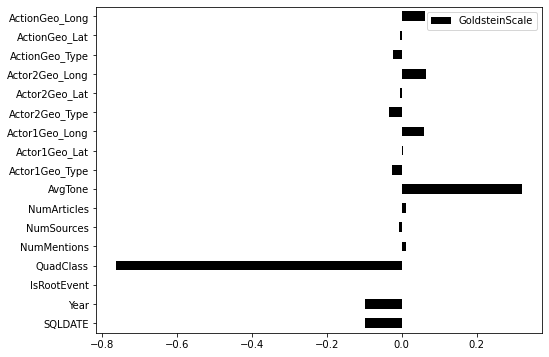

In [9]:
# plotting Pearson correlation
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')

# Model1 : Gradient Boosting Machine + H2O 

In [10]:
### Model1 - Gradient Boosting Machine + H2O ###
gbm_data = h2o.H2OFrame(data)
train, test = gbm_data.split_frame([0.7], seed=12345)
# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Train data rows = 44200, columns = 18
Test data rows = 19021, columns = 18


In [11]:
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f', model)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = %.2f Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1618008533905_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,64.0,64.0,15867.0,4.0,4.0,4.0,12.0,16.0,15.125




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4.6061277923676895
RMSE: 2.1461891324782374
MAE: 1.7177824414690022
RMSLE: NaN
Mean Residual Deviance: 4.6061277923676895

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 4.658780722766699
RMSE: 2.1584208863812218
MAE: 1.729595449503586
RMSLE: NaN
Mean Residual Deviance: 4.658780722766699

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-04-09 15:50:05,0.161 sec,0.0,4.496598,3.506370,20.219390,4.556738,3.556218,20.763862
1,,2021-04-09 15:50:06,0.680 sec,1.0,4.157176,3.250666,17.282113,4.214028,3.297661,17.758031
2,,2021-04-09 15:50:06,0.872 sec,2.0,3.859969,3.020465,14.899361,3.914179,3.065306,15.320800
3,,2021-04-09 15:50:06,0.965 sec,3.0,3.601420,2.823193,12.970228,3.652636,2.865792,13.341750
4,,2021-04-09 15:50:06,1.040 sec,4.0,3.378263,2.655360,11.412663,3.426627,2.696390,11.741774
5,,2021-04-09 15:50:06,1.133 sec,5.0,3.185533,2.504730,10.147620,3.231000,2.544286,10.439361
6,,2021-04-09 15:50:06,1.288 sec,6.0,3.026407,2.371847,9.159141,3.069399,2.410446,9.421212
7,,2021-04-09 15:50:06,1.366 sec,7.0,2.884570,2.249716,8.320746,2.924342,2.286747,8.551776
8,,2021-04-09 15:50:07,1.459 sec,8.0,2.763472,2.143409,7.636779,2.800173,2.178677,7.840971
9,,2021-04-09 15:50:07,1.616 sec,9.0,2.661626,2.061242,7.084253,2.695452,2.093210,7.265463



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,QuadClass,3.476488e+06,1.000000,0.979121
1,AvgTone,3.334838e+04,0.009593,0.009392
2,Actor2Geo_Long,7.573934e+03,0.002179,0.002133
3,Year,6.520444e+03,0.001876,0.001836
4,ActionGeo_Long,4.756654e+03,0.001368,0.001340
5,Actor1Geo_Long,3.730363e+03,0.001073,0.001051
6,ActionGeo_Lat,3.129713e+03,0.000900,0.000881
7,Actor2Geo_Lat,3.098358e+03,0.000891,0.000873
8,ActionGeo_Type,2.708014e+03,0.000779,0.000763
9,Actor1Geo_Lat,2.617558e+03,0.000753,0.000737


In [12]:
perf = model.model_performance(test)
print('H2O GBM Model Metrics on Test Set: ',perf)

H2O GBM Model Metrics on Test Set:  
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 4.658780722766699
RMSE: 2.1584208863812218
MAE: 1.729595449503586
RMSLE: NaN
Mean Residual Deviance: 4.658780722766699



In [13]:
model.r2(test)  # r_sq value on test set for GBM model

0.7721925489352026

# Model-2 : Isolation Forest Model + H2O

In [14]:
from h2o.estimators.isolation_forest import H2OIsolationForestEstimator
isofor_model = H2OIsolationForestEstimator(sample_size=5, ntrees=7)
isofor_model.train(training_frame = train)
print('IFM Test AUC = %.2f',isofor_model)

isolationforest Model Build progress: |███████████████████████████████████| 100%
IFM Test AUC = %.2f Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1618008533905_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,7.0,7.0,884.0,3.0,6.0,3.714286,4.0,8.0,5.428571




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 1.7231760396466516
Normalized Anomaly Score: 0.45675136326719956

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2021-04-09 15:50:16,0.083 sec,0.0,NaN,NaN
1,,2021-04-09 15:50:16,0.278 sec,1.0,1.822499,0.088750
2,,2021-04-09 15:50:16,0.373 sec,2.0,1.220057,0.519962
3,,2021-04-09 15:50:16,0.420 sec,3.0,1.933179,0.400058
4,,2021-04-09 15:50:16,0.468 sec,4.0,1.870277,0.502099
5,,2021-04-09 15:50:16,0.509 sec,5.0,1.746406,0.474219
6,,2021-04-09 15:50:16,0.557 sec,6.0,1.760485,0.494281
7,,2021-04-09 15:50:16,0.606 sec,7.0,1.723176,0.456751


In [15]:
perf = isofor_model.model_performance()
print('Isolation Forest Model + H2O Metrics :',perf)

Isolation Forest Model + H2O Metrics : 
ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 1.7231760396466516
Normalized Anomaly Score: 0.45675136326719956



In [16]:
print('IFE Mean Normalized Score : ',perf.mean_normalized_score())
print('IFE Mean Score : ',perf.mean_score())

IFE Mean Normalized Score :  0.45675136326719956
IFE Mean Score :  1.7231760396466516


In [17]:
### Conclusion : Suitable Model of the dataset is GBM Regression based Model ###